# Determine toponym ambiguity
In which we attempt to determine how much ambiguity there actually is within the Facebook data, according to how many anchor strings in the text point to ambiguous toponyms in OSM.

In [28]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Load data

In [2]:
entity_info = pd.read_csv('../../data/geo_files/PR_OSM/shp_files/combined_shp_data.tsv', sep='\t', index_col=0)

In [3]:
print(entity_info.head())

                                                 geometry_type feature_class  \
name                                                                           
Multipisos UPRRP                                       Polygon      building   
Escuela de Arquitecura y Escuela de Bellas Artes       Polygon      building   
Eugenio María de Hostos                                Polygon      building   
Teatro UPR                                             Polygon      building   
Complejo Deportivo Cosme Beitía Sálamo                 Polygon      building   

                                                    osm_id        lat  \
name                                                                    
Multipisos UPRRP                                  20885732 -66.044319   
Escuela de Arquitecura y Escuela de Bellas Artes  20887004 -66.046165   
Eugenio María de Hostos                           20887047 -66.047953   
Teatro UPR                                        20887143 -66.048651   
C

Drop nameless stuff!

In [19]:
entity_info = entity_info.loc[~ entity_info.index.isna()]
print(entity_info.shape[0])

66316


## Name ambiguity

How many entities are referenced by multiple names?

In [21]:
e_duplicate_counts = entity_info.groupby('osm_id').apply(lambda x: x.shape[0])
e_multi = e_duplicate_counts[e_duplicate_counts > 1]
print('%d/%d entities with multiple names'%(len(e_multi), entity_info.shape[0]))

1681/66316 entities with multiple names


In [22]:
entity_info_multi_names = entity_info[entity_info.loc[:, 'osm_id'].isin(e_multi.index)].sort_values('osm_id', inplace=False)
print(entity_info_multi_names.head(20))

                                        geometry_type   feature_class  \
name                                                                    
Cuartel de Ballajá                            Polygon          museum   
Cuartel de Ballajá                            Polygon        building   
Galería Nacional                              Polygon        building   
Galería Nacional                              Polygon          museum   
Paddle Paradise                               Polygon            park   
Paddle Paradise                               Polygon            park   
Reserva Natural Aguas Buenas                  Polygon  nature_reserve   
Reserva Natural Aguas Buenas                  Polygon          forest   
Robinson School                               Polygon        building   
Robinson School                               Polygon          school   
Estacionamiento Luis A. Ferré                 Polygon         parking   
Estacionamiento Luis A. Ferré                 Polyg

OK! It looks like all the duplicate entities are just classified under multiple feature classes.

What about actual duplicates?

In [23]:
e_name_counts = entity_info.groupby('osm_id').apply(lambda x: x.index.nunique())
e_multi_names = e_name_counts[e_name_counts > 1]
print('%d/%d entities have multiple names'%(len(e_multi_names), entity_info.shape[0]))

0/66316 entities have multiple names


In [24]:
print(entity_info[entity_info.index.to_series().apply(lambda x: 'Urb' in x)])

                                geometry_type   feature_class     osm_id  \
name                                                                       
Cancha Urb. Jardines                  Polygon        building  204521460   
Centro Urbano del Condado             Polygon        building  279217293   
Lavander Urban Vintage Boutique       Polygon        building  358994701   
Urbanización Ocean Park               Polygon        building  358996211   
Escuela Superior Urbana Nueva         Polygon        building    7640406   
Urb. Toaville                         Polygon     residential   55177504   
Bosque Urbano de San Patricio         Polygon          forest   58064660   
Bosque Urbano de San Patricio         Polygon  nature_reserve   58064660   
Urb. Llanos de Providencia            Polygon     residential   60137991   
Urb. Fajardo Gardens                  Polygon     residential   60397641   
Urbanizacion Borinquen                Polygon     residential   60697750   
Urbanización

Ha! So there is actually no example of an entity corresponding to multiple names, although this is certainly happening in the data:

- `Urb. Rexmanor` <=> `Urbanización Rexmanor`

## Entity name ambiguity
What is the average number of unique entities to which a name refers?

In [27]:
entity_id_to_name_count = entity_info.groupby(entity_info.index).apply(lambda x: x.loc[:, 'osm_id'].nunique()).sort_values(inplace=False, ascending=False)
print(entity_id_to_name_count.head())

name
Calle 1    1126
Calle 2    1052
Calle 3     976
Calle 4     875
Calle 5     745
dtype: int64


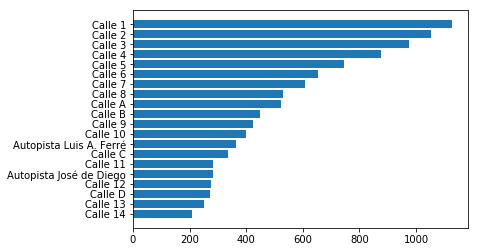

In [33]:
top_k = 20
y_pos = pd.np.arange(top_k)[::-1]
y_tick_labels = map(lambda x: x.decode('utf-8'), entity_id_to_name_count.index[:top_k])
plt.barh(y_pos, entity_id_to_name_count.values[:top_k])
plt.yticks(y_pos, y_tick_labels)
plt.show()

As expected, the most ambiguous entities are roads (`Calle` = "road", `Autopista` = "highway").

## Entity name ambiguity (in data)
Same thing but using our real data.

In [50]:
import os
location_info = pd.read_csv('../../data/facebook-maria/location_group_data.tsv', sep='\t', index_col=False)
print(location_info.head())
group_ids = location_info.loc[:, 'group_id']
date_str = '2017-09-20_2017-10-20'
data_dir = '../../data/facebook-maria/'
file_base_str = os.path.join(data_dir,'%s_%s_facebook_posts.tsv')
group_files = [file_base_str%(g, date_str) for g in group_ids]
print(len(group_files))

  location_name          group_id  \
0        Aguada  1724474021195839   
1     Aguadilla   117529462276443   
2     Aguadilla  1390525734396603   
3  Aguas Buenas  1723084327997466   
4  Aguas Buenas   210130182858104   

                                          group_name  
0                      Huracan Maria Anasco y Aguada  
1                            Huracan Maria Aguadilla  
2  Huracan Maria - Aguadilla - Ceiba Baja y Guerrero  
3                         Aguas Buenas Huracan Maria  
4  Huracán María Comerío Bayamón Aguas Buenas, ar...  
68


In [51]:
import data_helpers
reload(data_helpers)
from data_helpers import get_all_group_files
group_files = get_all_group_files()
print(len(group_files))

62


In [58]:
combined_txt = pd.concat([pd.read_csv(f, sep='\t', index_col=False).loc[:, 'status_message'].dropna(inplace=False) for f in group_files])
combined_txt.index = pd.np.arange(len(combined_txt))
print(len(combined_txt))
print(combined_txt.head())
print(combined_txt.shape)

31413
0    Estoy preocupada por mi tia vicky vazquez que ...
1    Para alguien que lo necesite... Dale Share..A ...
2         One unsafe well in Dorado on Carr 694 km 4.5
3    En apoyo al alcalde Carlos Lopez y al municipi...
4    Pueblo de Puerto Rico no se monten en las gran...
Name: status_message, dtype: object
(31413,)


In [59]:
combined_txt[10]

'Videos de Dorado dos semanas despues del Huracan Mar\xc3\xada'

In [61]:
min_df = 1
ngram_range = (1,5)
cv = CountVectorizer(min_df=min_df, lowercase=True, ngram_range=ngram_range)
dtm = cv.fit_transform(combined_txt)

In [75]:
ivoc = {v : k for k,v in cv.vocabulary_.iteritems()}

In [67]:
print(dtm.shape)
out_file_name = '../../data/facebook-maria/combined_group_status_dtm.npz'
pd.np.savez(out_file_name, dtm)
# save vocab too!
vocab_out_file_name = '../../data/facebook-maria/combined_group_status_dtm_vocab.csv'
vocab_series = pd.Series(cv.vocabulary_)
vocab_series.to_csv(vocab_out_file_name, encoding='utf-8')

(31413, 2294394)


Now! Figure out the lexicon intersection.

In [89]:
MIN_CHAR_LEN = 3
filter_lexicon_entry = lambda x: not x.isdigit() and len(x) >= MIN_CHAR_LEN
lexicon = entity_info.index.tolist()
lexicon_lower = map(lambda x: x.lower(), lexicon)
lexicon_clean = filter(filter_lexicon_entry, lexicon_lower)
lexicon_relevant = list(set(lexicon_clean) & set(cv.vocabulary_.keys()))
lexicon_idx = sorted(vocab_series.loc[lexicon_relevant])
dtm_entity = dtm[:, lexicon_idx]
print(dtm_entity.shape)
lexicon_full_dtm_idx_lookup = dict(zip(pd.np.arange(dtm_entity.shape[0]), lexicon_idx))

(31413, 1502)


In [91]:
# get sums
dtm_entity_sums = pd.np.array(dtm_entity.sum(axis=0))[0]
# convert to proper index
new_idx = [lexicon_full_dtm_idx_lookup[i] for i in pd.np.arange(dtm_entity_sums.shape[0])]
dtm_entity_sums = pd.Series(dtm_entity_sums, index=new_idx)
dtm_entity_sums.index = [ivoc[i] for i in dtm_entity_sums.index]
dtm_entity_sums.sort_values(inplace=True, ascending=False)
print(dtm_entity_sums.head(100))

puerto rico     3076
calle           2569
pueblo          1768
guayama         1560
coamo           1088
la familia      1003
ponce            889
vega alta        886
barranquitas     799
quebradillas     757
correo           627
camino           614
san juan         600
yabucoa          594
vega baja        571
patillas         559
corozal          549
cayey            532
cidra            481
arroyo           454
parque           438
florida          413
walmart          403
utuado           400
escuela          391
cancha           381
lajas            363
jardines         347
quebrada         310
angel            274
                ... 
palmas           112
toa baja         111
capilla          111
farmacia         110
funeraria        110
morovis          109
ciales           109
camuy            108
house            107
caribe           106
aibonito         106
delgado          106
juanita          104
edificio         104
alicea           102
res              102
santa rita   

Great. There's obviously a lot of noise here but how many of these mentions are ambiguous?

In [157]:
# unique, then weighted
entity_lower_name_to_id_count = entity_info.groupby(map(lambda x: x.lower(), entity_info.index)).apply(lambda x: x.loc[:, 'osm_id'].nunique())
relevant_entity_names = dtm_entity_sums.index.tolist()
relevant_name_counts = entity_lower_name_to_id_count.loc[relevant_entity_names].sort_values(inplace=False, ascending=False)
print(relevant_name_counts.head(100))
print(relevant_name_counts.tail(100))

calle 10             398
calle 11             282
calle 12             274
calle 13             250
calle 14             210
calle marginal       195
calle 15             186
calle 16             152
calle 17             143
calle principal      140
calle 19             128
calle 18             126
calle 21             111
calle amapola        105
calle 22             103
calle 23             101
calle gardenia        86
calle 24              77
calle margarita       76
calle ceiba           72
calle 25              71
calle azucena         69
calle flamboyan       68
burger king           68
calle girasol         67
calle esmeralda       67
calle 26              66
calle laurel          63
camino vecinal        59
calle 27              59
                    ... 
puma                  31
calle los robles      31
calle geranio         30
calle nueva           30
calle rubi            30
calle 3a              28
calle san miguel      28
calle perla           28
calle venus           27


Ha! I knew it. Most of the ambiguous mentions in the data stem from street names.

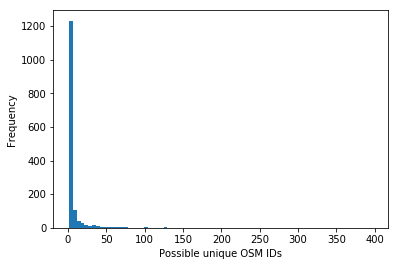

In [95]:
bins = 100
plt.hist(relevant_name_counts, bins=relevant_name_counts.nunique())
plt.xlabel('Possible unique OSM IDs')
plt.ylabel('Frequency')
plt.show()

Most of the anchor strings in the dataset only refer to one unique OSM entity.

In [98]:
relevant_name_counts_weighted = relevant_name_counts.groupby(relevant_name_counts.values).apply(lambda x: dtm_entity_sums.loc[x.index].sum())
print(relevant_name_counts_weighted)

1      32838
2       3217
3       2680
4        544
5        399
6        773
7        572
8       2050
9        247
10       137
11        43
12        38
13        38
14        12
15        13
16        17
17       120
18        32
19         8
20        16
21        10
22        31
23        18
24       134
25         4
26        13
27        38
28         6
30         8
31        81
       ...  
53         8
57         1
58        20
59         2
63         1
66         1
67         5
68        24
69         2
71         1
72         6
76         3
77         3
86        11
101        4
103        4
105        1
111        1
126       13
128        8
140       22
143       10
152        8
186       17
195       11
210       31
250        3
274       12
282       11
398       30
Length: 77, dtype: int64


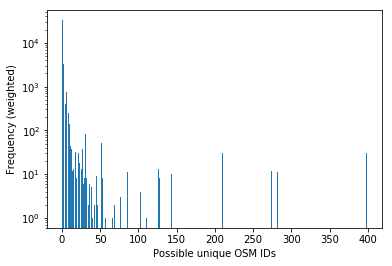

In [102]:
plt.bar(relevant_name_counts_weighted.index, relevant_name_counts_weighted)
plt.xlabel('Possible unique OSM IDs')
plt.ylabel('Frequency (weighted)')
plt.yscale('log')
plt.show()

What is the total count of ambiguous entity mentions?

In [103]:
relevant_ambiguous_frequency = relevant_name_counts_weighted[relevant_name_counts_weighted.index > 1].sum()
print('%d/%d mentions are potentially ambiguous'%(relevant_ambiguous_frequency, dtm_entity_sums.sum()))

11799/44637 mentions are potentially ambiguous


Actually not terrible! Unless the bulk of those mentions are easily disambiguated by the social group setting (e.g., only one `Calle 10` in Guayama).

In [106]:
entity_municipality_counts = entity_info.groupby(map(lambda x: x.lower(), entity_info.index)).apply(lambda x: x.loc[:, 'municipality'].nunique()).sort_values(inplace=False, ascending=False)
relevant_municipality_counts = entity_municipality_counts.loc[relevant_entity_names].sort_values(inplace=False, ascending=False)
print(relevant_municipality_counts.head(20))

calle 10           65
calle 11           57
calle 13           54
calle 12           53
calle amapola      47
calle 15           47
calle 14           47
calle principal    42
calle 16           42
calle gardenia     40
calle 18           39
calle 17           39
calle laurel       37
calle ceiba        37
calle girasol      37
calle 19           36
burger king        36
calle azucena      36
calle margarita    36
calle marginal     35
dtype: int64


Some of these streets are common across municipalities. AWESOME.

### Within-municipality ambiguity
How often does a toponym occur more than once within the same municipality? LET'S FIND OUT.

In [118]:
entity_info_lower = entity_info.copy()
entity_lower_index = map(lambda x: x.lower(), entity_info.index)
entity_info_lower.index = entity_lower_index

In [122]:
print(entity_info_lower.head())

                                                 geometry_type feature_class  \
multipisos uprrp                                       Polygon      building   
escuela de arquitecura y escuela de bellas artes       Polygon      building   
eugenio maría de hostos                                Polygon      building   
teatro upr                                             Polygon      building   
complejo deportivo cosme beitía sálamo                 Polygon      building   

                                                    osm_id        lat  \
multipisos uprrp                                  20885732 -66.044319   
escuela de arquitecura y escuela de bellas artes  20887004 -66.046165   
eugenio maría de hostos                           20887047 -66.047953   
teatro upr                                        20887143 -66.048651   
complejo deportivo cosme beitía sálamo            20887609 -66.046724   

                                                        lon   shp_type  \
multip

In [133]:
from __future__ import division
def get_multi_occurrence_pct(municipality_counts):
    if(len(municipality_counts) == 0):
        print('error at counts\n%s'%(municipality_counts))
    multi_occurrence_pct = len(municipality_counts[municipality_counts > 1]) / len(municipality_counts)
    return multi_occurrence_pct
test_e_name = 'calle 10'
test_df = entity_info_lower.loc[test_e_name]
print(test_df.shape[0])
test_df_multi_occurrence = get_multi_occurrence_pct(test_df.groupby('municipality').apply(lambda x: x.shape[0]))
print(test_df_multi_occurrence)

398
0.861538461538


In [137]:
print(entity_info_lower[entity_info_lower.loc[:, 'municipality'].isna()])

                                           geometry_type   feature_class  \
faro de punta tuna                               Polygon        building   
mooring posts                                    Polygon        building   
mooring post                                     Polygon        building   
ss                                               Polygon        building   
vieques national wildlife refuge                 Polygon  nature_reserve   
cayo ratón                                       Polygon  nature_reserve   
cayos geniquí                                    Polygon  nature_reserve   
cayo lobo                                        Polygon  nature_reserve   
los gemelos                                      Polygon  nature_reserve   
cayo tiburón                                     Polygon  nature_reserve   
cayo botella                                     Polygon  nature_reserve   
cayos geniquí                                    Polygon  nature_reserve   
cayo yerba  

In [139]:
entity_info_lower_non_na = entity_info_lower[~ entity_info_lower.loc[:, 'municipality'].isna()]
entity_multi_occurrence_pct = entity_info_lower_non_na.groupby(entity_info_lower_non_na.index).apply(lambda x: get_multi_occurrence_pct(x.groupby('municipality').apply(lambda y: y.shape[0])))

In [142]:
entity_multi_occurrence_pct.sort_values(inplace=True, ascending=False)
print(entity_multi_occurrence_pct.head(20))

calle enrique vázquez              1.0
biblioteca josé m. lázaro          1.0
blvd rio grande plantation         1.0
bmx track                          1.0
calle raul ruíz tollinchi          1.0
calle realeza                      1.0
sector la grüa                     1.0
calle rebollo                      1.0
biblioteca general                 1.0
biblioteca juan de valdes          1.0
calle reina sofía                  1.0
calle via 7                        1.0
sector las piedra                  1.0
calle regina medina                1.0
sector las lajas                   1.0
biblioteca pura platti gonzáles    1.0
sector las guaba                   1.0
calle refugio                      1.0
sector hector ruiz                 1.0
sector herminio reyes              1.0
dtype: float64


In [148]:
relevant_entity_multi_occurrence_pct = entity_multi_occurrence_pct.loc[relevant_entity_names].sort_values(inplace=False, ascending=False)
print(relevant_entity_multi_occurrence_pct.head(20))
print('%d/%d entity strings have some amount of ambiguity within the same municipality'%
     (len(relevant_entity_multi_occurrence_pct[relevant_entity_multi_occurrence_pct > 0.0]), 
      len(relevant_entity_names)))

calle laureano           1.0
la paz                   1.0
parque forestal          1.0
paseo de la princesa     1.0
calle derkes             1.0
calle gatty              1.0
los gomez                1.0
naguabo                  1.0
sector asomante          1.0
camino juan ramos        1.0
estudiantes              1.0
pirilo                   1.0
the place                1.0
the pink house           1.0
iglesia bautista         1.0
manejo de emergencias    1.0
camino morcelo           1.0
calle octavio rivera     1.0
caoba                    1.0
los balcones             1.0
dtype: float64
596/1502 entity strings have some amount of ambiguity within the same municipality


/hg190/istewart6/crisis_language/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


OK! More than a third of entity strings cannot be disambiguated by the municipality alone. Not a huge number but I'll take what I can get!

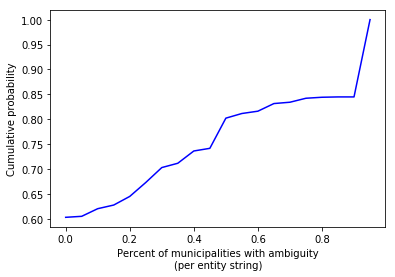

In [155]:
relevant_entity_multi_occurrence_pct = relevant_entity_multi_occurrence_pct.fillna(0, inplace=False).sort_values(inplace=False, ascending=True)
bins = 20
values, base = pd.np.histogram(relevant_entity_multi_occurrence_pct, bins=bins)
cumulative = pd.np.cumsum(values) / len(relevant_entity_multi_occurrence_pct)
plt.plot(base[:-1], cumulative, color='b')
plt.xlabel('Percent of municipalities with ambiguity\n(per entity string)')
plt.ylabel("Cumulative probability")
plt.show()

Look at that! Steady increase in proportion of entities with ambiguity, with a big spike around 90%.